# Diffusion Music Generation Level 1

### imports

In [1]:
import IPython

import torch
from torch.utils.data import DataLoader
import yaml
import matplotlib.pyplot as plt
import torchaudio

from models.multi_level_vqvae import MultiLvlVQVariationalAutoEncoder
from models.diffusion_vit import DiffusionViT
from models.diffusion_unet import WaveNetDiffusion
from models.transformer_vqvae import TransformerVQVAE
from loaders.latent_loaders import Lvl2InputDataset
from utils.other import load_cfg_dict

### Load configuration files and add weight paths

In [2]:
config_path = "config/lvl1_config.yaml"
weights_path = "model_weights/lvl1_vqvae.ckpt"
cfg = load_cfg_dict(config_path)

config_path_diff = "config/diff_lvl1_wavenet_config.yaml"
weights_path_diff = "model_weights/lvl1_diff.ckpt"
cfg_diff = load_cfg_dict(config_path_diff)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load the models

In [3]:
model_vqvae = MultiLvlVQVariationalAutoEncoder.load_from_checkpoint(weights_path, **cfg, strict=False).to(device=device)
model_vqvae.eval()

model_diffusion = WaveNetDiffusion.load_from_checkpoint(weights_path_diff, **cfg_diff, strict=False).to(device=device)
model_diffusion.eval()

/home/vovatch/anaconda3/envs/VovaTch/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.3, which is newer than your current Lightning version: v1.9.0
  rank_zero_warn(


WaveNetDiffusion(
  (encoder): ModuleList(
    (0): Conv1d(8, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Conv1d(64, 128, kernel_size=(15,), stride=(1,), padding=(7,))
    (2): Conv1d(128, 192, kernel_size=(15,), stride=(1,), padding=(7,))
    (3): Conv1d(192, 256, kernel_size=(15,), stride=(1,), padding=(7,))
    (4): Conv1d(256, 320, kernel_size=(15,), stride=(1,), padding=(7,))
    (5): Conv1d(320, 384, kernel_size=(15,), stride=(1,), padding=(7,))
    (6): Conv1d(384, 448, kernel_size=(15,), stride=(1,), padding=(7,))
    (7): Conv1d(448, 512, kernel_size=(15,), stride=(1,), padding=(7,))
  )
  (decoder): ModuleList(
    (0): Conv1d(1024, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(960, 448, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(832, 384, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): Conv1d(704, 320, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): Conv1d(576, 256, kernel_size=(5,), stride=(1,), padding=(2,))


### Define the player

In [4]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/mp3" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

## Load the diffusion dataset and display the latents

Loading file data/music_samples/001-datatensor_gen.pt...
Music file data/music_samples/001-datatensor_gen.pt is loaded.
Loading file data/music_samples/001-metadata_gen.pkl...
Music file data/music_samples/001-metadata_gen.pkl is loaded.
Current track is data/music_samples/01 Infected Mushroom - Bust A Move (Bliss Remix).mp3


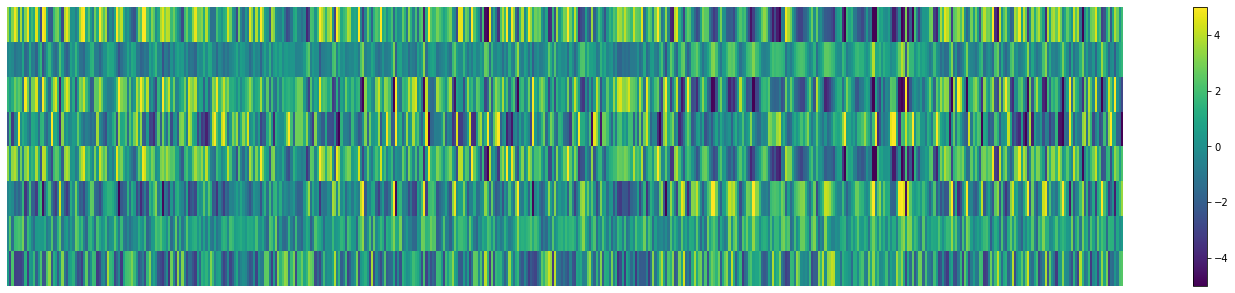

In [10]:
dataset = Lvl2InputDataset(preload=True, **cfg_diff)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for sample in dataloader:
    lvl2_sample = sample['music slice'].squeeze(0)
    print(f"Current track is {sample['track name'][0]}")
    break

plt.figure(figsize=(25, 5))
plt.matshow(lvl2_sample.cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-5, vmax=5.0)
plt.colorbar()
plt.axis('off')
plt.show()

## Run diffusion model

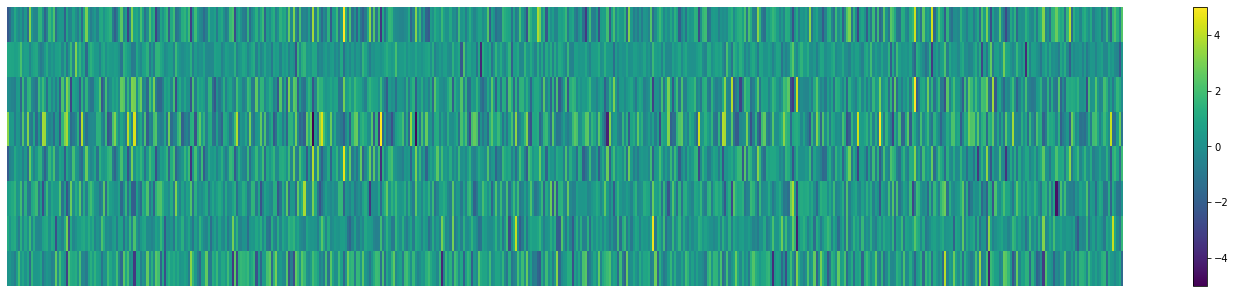

In [11]:
random_noise_start = torch.randn_like(lvl2_sample)
lvl2_latent_gen = model_diffusion.denoise(lvl2_sample.unsqueeze(0).to(device), show_process_plots=False).squeeze(0)

plt.figure(figsize=(25, 5))
plt.matshow(lvl2_latent_gen.cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-5, vmax=5.0)
plt.colorbar()
plt.axis('off')
plt.show()

## Generate music

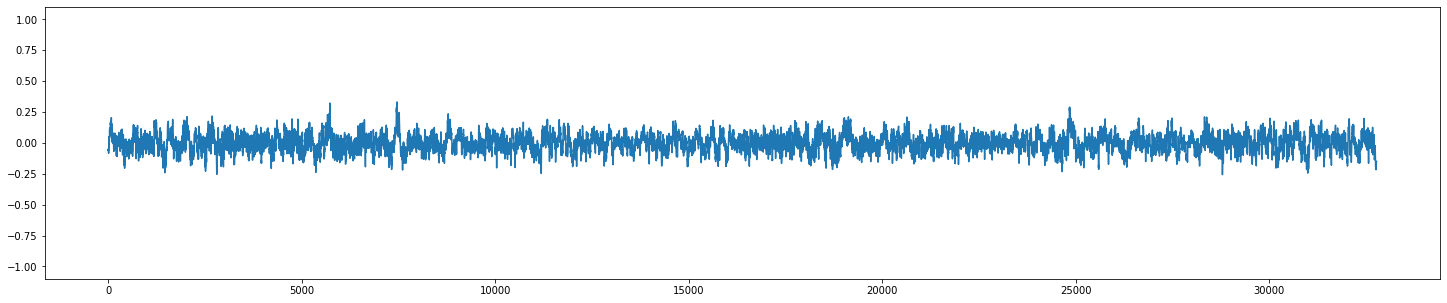

In [9]:
music_generated, _ = model_vqvae.decode(lvl2_latent_gen.unsqueeze(0))
music_sample_rec = music_generated.view((1, -1))
plt.figure(figsize=(25, 5))
plt.plot(music_sample_rec[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")